Data obtained from project "abstract"
```
epochs[-1].get_data().shape

e = epochs[-1][["img","sf","toon"]]

X = e.get_data()[:,:28,:]
Y = get_labels_from_events(e.events, e.event_id)

X.shape

assert X.shape[0] == Y.shape[0]

with open("subj28.pkl", "wb") as f:
    pickle.dump(epochs[-1], f, protocol=pickle.HIGHEST_PROTOCOL)
```



.File "subj28.pkl" is a pickled tuple of two numpy arrays: X and Y. X has shape (797 epochs, 28 channels, 501 samples) and Y has shape (797, 4). It is three experimental categories and five affective classes one-hot-encoded into 4 dimensions. 

```python
    m = {"0": np.array([ 0, 0]),
        "1": np.array([ 1, 1]),
        "2": np.array([-1, 1]),
        "3": np.array([-1,-1]),
        "4": np.array([ 1,-1])}
    c = {"img": np.array([0, 0]),
        "sf":   np.array([1, 0]),
        "toon": np.array([0, 1])}
```

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import torch
import matplotlib.pyplot as plt
import pickle
# !pip install torchmetrics
import torchmetrics

In [2]:
with open("ex/subj28.pkl", 'rb') as f:
    X,Y = pickle.load(f)
print(X.shape)
print(Y.shape)

(797, 28, 501)
(797, 4)


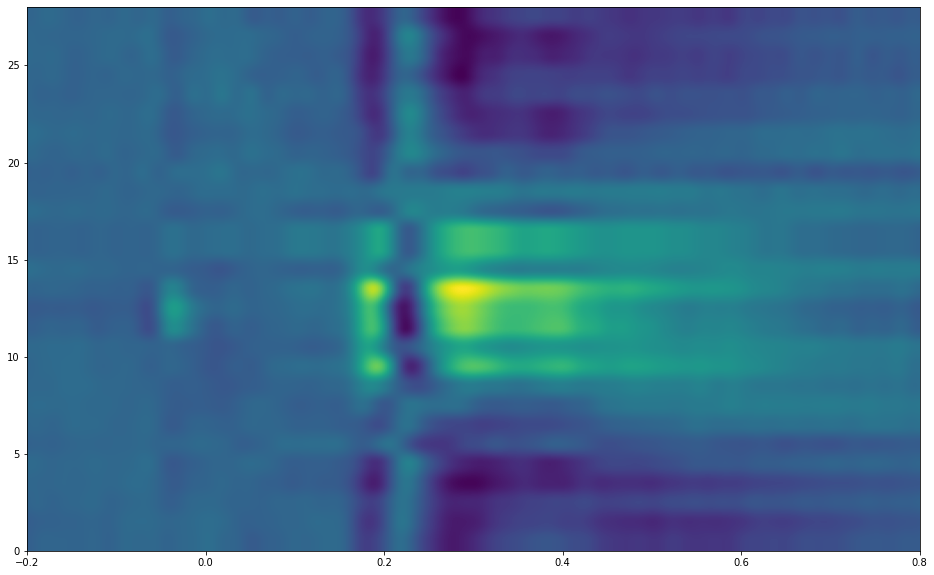

In [3]:
fs = 500
tmin = -0.200
tmax = 0.800
ch_names = ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'Cz', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Pz', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
t = np.linspace(tmin, tmax, X.shape[2])
fig, ax = plt.subplots(figsize=(16,10))
ax.imshow(X.mean(axis=0), extent=[tmin, tmax,0,28], interpolation=None)
ax.set_aspect("auto")
plt.show()

Simplest attempt, every sample in every channel is a variable observed on every trial.

In [4]:
n_channels = X.shape[1]
n_samples = X.shape[2]
X = X.reshape(797,-1)
print(X.shape)

(797, 14028)


In [5]:
Y = Y[:,:2].astype("int")
print(Y.shape)

(797, 2)


(797, 14028)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


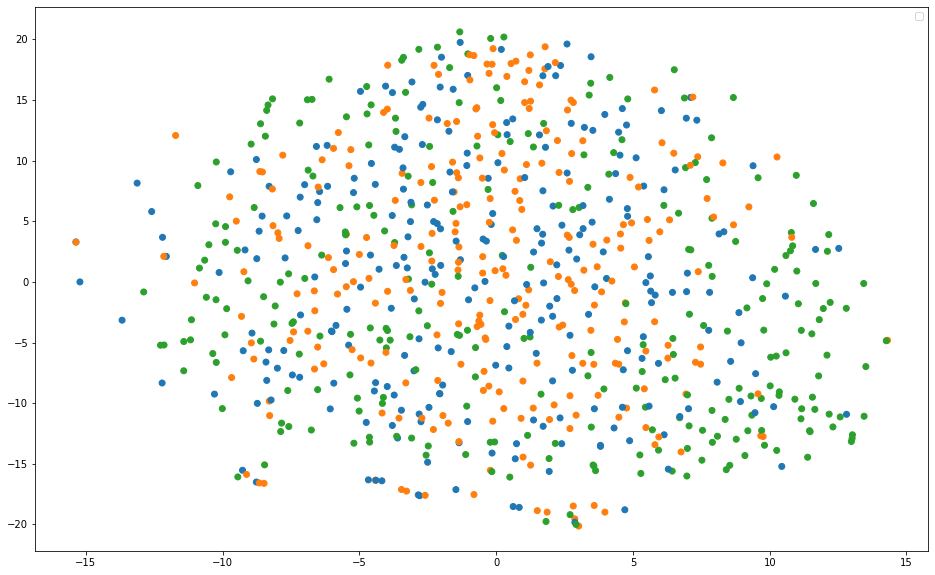

In [6]:
print(X.shape)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap([a*2 + b for a,b in Y[:,:2]]))
plt.legend()

The features don't seem to be linearly separable, so a high accuracy is not expected.

A 70/30 split is done for testing and training purposes. This evaluates the model's generalizability.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## The linear model

In [8]:
from torch.autograd import Variable
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
   
    def init(self, init_func, *params, **kwargs):
        for p in self.parameters():
            init_func(p, *params, **kwargs)

In [9]:
inputDim = X.shape[1]        # takes variable 'x' 
outputDim = Y.shape[1]       # takes variable 'y'
learningRate = 0.1 
epochs = 500

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [11]:
model = LogisticRegression(inputDim, outputDim)
model.to(device)

LogisticRegression(
  (linear): Linear(in_features=14028, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [12]:
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [13]:
ltr_curve = []
atr_curve  = []
lts_curve = []
ats_curve  = []
model.init(torch.nn.init.uniform_)
for epoch in range(epochs):
    # Train Set
    inputs = Variable(torch.tensor(X_train.astype(np.float32))).to(device)
    labels = Variable(torch.tensor(y_train.astype(np.float32))).to(device)

    optimizer.zero_grad()
    y_hat = model(inputs)

    loss = criterion(y_hat, labels)
    train_loss = loss.item()
    ltr_curve.append(train_loss)
    
#     train_acc = torch.sum(y_hat.round() == labels) / labels.size(0)
#     atr_curve.append(train_acc.cpu().detach().numpy())
    
    # Optimization
    loss.backward()
    optimizer.step()
    
    # Test set    
    y_hat = model(Variable(torch.tensor(X_test.astype(np.float32))).to(device))
    test_lbls = Variable(torch.tensor(y_test.astype(np.float32))).to(device)
    test_loss = criterion(y_hat, test_lbls)
    test_loss = test_loss.item()
    lts_curve.append(test_loss)
#     test_acc = torch.sum(y_hat.round() == test_lbls) / test_lbls.size(0)
#     ats_curve.append(test_acc.cpu().detach().numpy())


    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.7732857465744019
epoch 1, loss 0.7699541449546814
epoch 2, loss 0.7667021155357361
epoch 3, loss 0.763528048992157
epoch 4, loss 0.7604302167892456
epoch 5, loss 0.7574069499969482
epoch 6, loss 0.7544565796852112
epoch 7, loss 0.7515774369239807
epoch 8, loss 0.7487680912017822
epoch 9, loss 0.7460268139839172
epoch 10, loss 0.7433521747589111
epoch 11, loss 0.7407426238059998
epoch 12, loss 0.7381966710090637
epoch 13, loss 0.7357128858566284
epoch 14, loss 0.7332897782325745
epoch 15, loss 0.7309260368347168
epoch 16, loss 0.7286201119422913
epoch 17, loss 0.7263708710670471
epoch 18, loss 0.7241767644882202
epoch 19, loss 0.7220366597175598
epoch 20, loss 0.7199492454528809
epoch 21, loss 0.7179131507873535
epoch 22, loss 0.7159273624420166
epoch 23, loss 0.7139905095100403
epoch 24, loss 0.7121015191078186
epoch 25, loss 0.7102591395378113
epoch 26, loss 0.7084622979164124
epoch 27, loss 0.7067099213600159
epoch 28, loss 0.7050008773803711
epoch 29, loss 0.70333421

epoch 240, loss 0.6372770071029663
epoch 241, loss 0.6372665762901306
epoch 242, loss 0.6372563242912292
epoch 243, loss 0.637246310710907
epoch 244, loss 0.6372365355491638
epoch 245, loss 0.6372269988059998
epoch 246, loss 0.6372177004814148
epoch 247, loss 0.6372085809707642
epoch 248, loss 0.6371995806694031
epoch 249, loss 0.6371909379959106
epoch 250, loss 0.6371824741363525
epoch 251, loss 0.637174129486084
epoch 252, loss 0.6371659636497498
epoch 253, loss 0.6371580362319946
epoch 254, loss 0.6371502876281738
epoch 255, loss 0.6371425986289978
epoch 256, loss 0.6371351480484009
epoch 257, loss 0.6371279358863831
epoch 258, loss 0.63712078332901
epoch 259, loss 0.6371139287948608
epoch 260, loss 0.6371071338653564
epoch 261, loss 0.6371005177497864
epoch 262, loss 0.6370940208435059
epoch 263, loss 0.6370877027511597
epoch 264, loss 0.6370814442634583
epoch 265, loss 0.6370754241943359
epoch 266, loss 0.6370695233345032
epoch 267, loss 0.63706374168396
epoch 268, loss 0.63705813

epoch 476, loss 0.636813223361969
epoch 477, loss 0.636813223361969
epoch 478, loss 0.6368131637573242
epoch 479, loss 0.6368131041526794
epoch 480, loss 0.6368131041526794
epoch 481, loss 0.6368129849433899
epoch 482, loss 0.6368129253387451
epoch 483, loss 0.6368128657341003
epoch 484, loss 0.6368128657341003
epoch 485, loss 0.6368128657341003
epoch 486, loss 0.6368128061294556
epoch 487, loss 0.6368128061294556
epoch 488, loss 0.6368128061294556
epoch 489, loss 0.636812686920166
epoch 490, loss 0.636812686920166
epoch 491, loss 0.6368125677108765
epoch 492, loss 0.6368126273155212
epoch 493, loss 0.6368125677108765
epoch 494, loss 0.6368124485015869
epoch 495, loss 0.6368124485015869
epoch 496, loss 0.6368124485015869
epoch 497, loss 0.6368123888969421
epoch 498, loss 0.6368123292922974
epoch 499, loss 0.6368123292922974


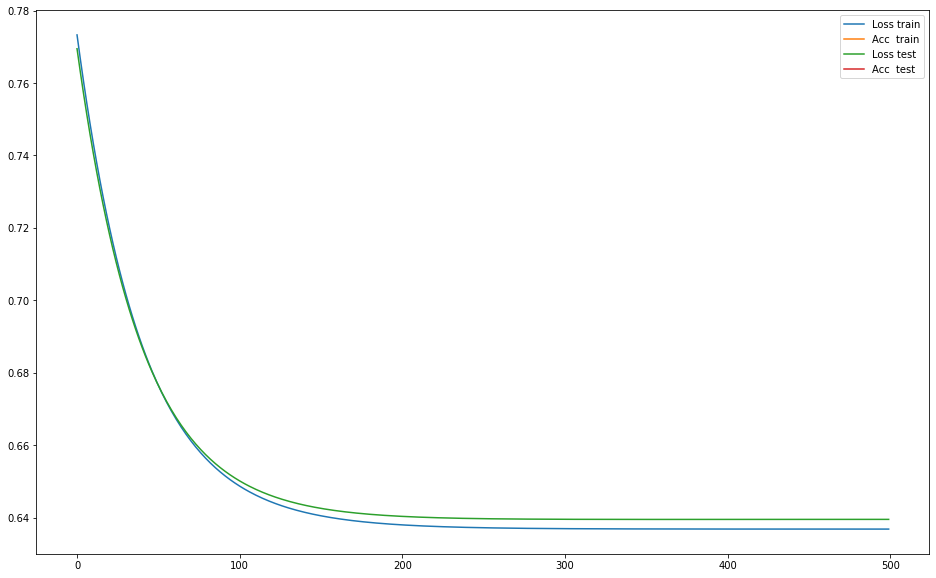

In [14]:
fig = plt.figure(figsize=(16,10))
plt.plot(ltr_curve, label="Loss train")
plt.plot(atr_curve, label="Acc  train")
plt.plot(lts_curve, label="Loss test")
plt.plot(ats_curve, label="Acc  test")
plt.legend()
plt.show()

In [15]:
coef = [p.cpu().detach().numpy() for p in model.parameters()]
print(coef)

[array([[0.8527634 , 0.8973236 , 0.36677212, ..., 0.5545366 , 0.9318392 ,
        0.8905992 ],
       [0.0349933 , 0.43498886, 0.11090744, ..., 0.1765004 , 0.55027324,
        0.93405825]], dtype=float32), array([-0.6547002, -0.7194757], dtype=float32)]


In [16]:
print(coef[0].shape)
W = coef[0].reshape(2, n_channels, n_samples)
print(W.shape)

(2, 14028)
(2, 28, 501)


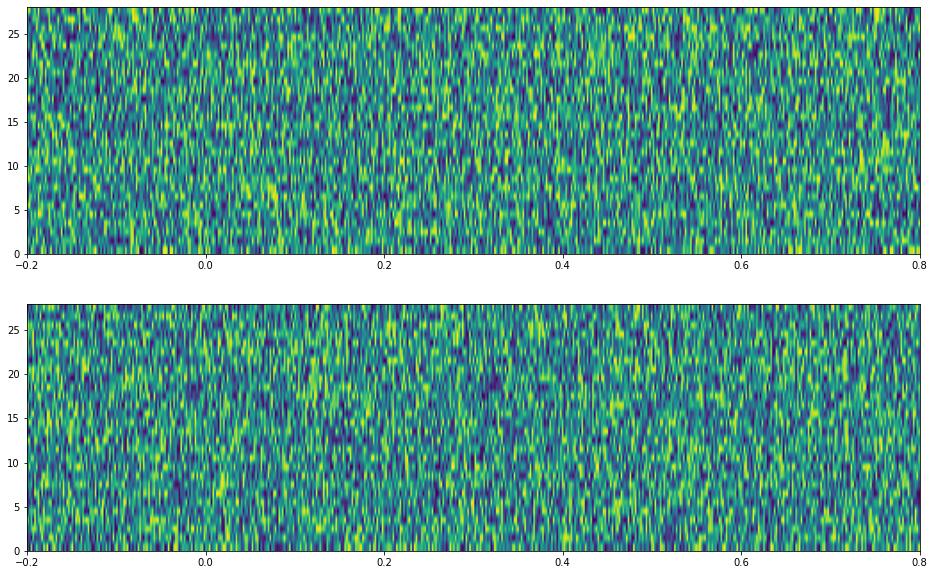

In [17]:
fig, axs = plt.subplots(2,1,figsize=(16,10))
axs[0].imshow(W[0,:,:], extent=[tmin, tmax,0,28], interpolation=None)
axs[0].set_aspect("auto")
axs[1].imshow(W[1,:,:], extent=[tmin, tmax,0,28], interpolation=None)
axs[1].set_aspect("auto")
plt.show()

# Visualization

In [18]:
inputs = Variable(torch.tensor(X.astype(np.float32))).to(device)
labels = Variable(torch.tensor(Y.astype(np.float32))).to(device)

y_hat = model(inputs).round().cpu().detach().numpy()
print(y_hat.shape)

(797, 2)


In [19]:
Y.shape

(797, 2)

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_hat, Y)

0.3299874529485571

In [21]:
from sklearn.model_selection import KFold

inputDim = X.shape[1]        # takes variable 'x' 
outputDim = Y.shape[1]       # takes variable 'y'
learningRate = 0.1 
epochs = 200 # Early stopping.

kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [22]:
def train_model(X_train, Y_train, X_test, Y_test):
    model = LogisticRegression(inputDim, outputDim)
    model.to(device)
    criterion = torch.nn.BCELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    model.init(torch.nn.init.uniform_)
    ltr_curve, atr_curve = [], [] # Train and test loss and accuracy 
    lts_curve, ats_curve = [], []
    for epoch in range(epochs):
        # Train Set
        inputs = Variable(torch.tensor(X_train.astype(np.float32))).to(device)
        labels = Variable(torch.tensor(Y_train.astype(np.float32))).to(device)

        optimizer.zero_grad()
        y_hat = model(inputs)

        loss = criterion(y_hat, labels)
        train_loss = loss.item()
        ltr_curve.append(train_loss)

    #     train_acc = torch.sum(y_hat.round() == labels) / labels.size(0)
    #     atr_curve.append(train_acc.cpu().detach().numpy())

        # Optimization
        loss.backward()
        optimizer.step()

        # Test set    
        y_hat = model(Variable(torch.tensor(X_test.astype(np.float32))).to(device))
        test_lbls = Variable(torch.tensor(Y_test.astype(np.float32))).to(device)
        test_loss = criterion(y_hat, test_lbls)
        test_loss = test_loss.item()
        lts_curve.append(test_loss)
    #     test_acc = torch.sum(y_hat.round() == test_lbls) / test_lbls.size(0)
    #     ats_curve.append(test_acc.cpu().detach().numpy())


#     print('epoch {}, loss {}'.format(epoch, loss.item()))
    return lts_curve[-1]

```python
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
```

loss 0.6598218083381653
loss 0.6295024156570435
loss 0.6432970762252808
loss 0.6366478800773621
loss 0.6544100642204285


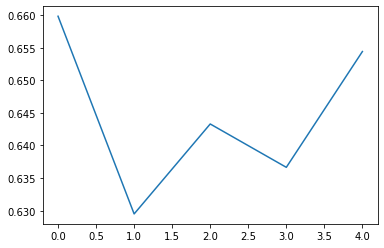

In [23]:
cvl = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index,:], Y[test_index,:]
#     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
#     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
    cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    print('loss {}'.format(cvl[-1]))
plt.plot(cvl)

In [24]:
import seaborn as sns

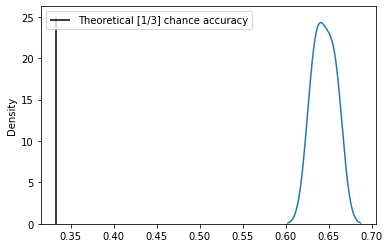

In [25]:
cross_validation_scores = cvl
sns.kdeplot(cvl)
plt.vlines([1/3], 0, 25, colors='k', linestyles='solid', label='Theoretical [1/3] chance accuracy')
plt.legend()


Training 0, loss: 0.6488996148109436

Training 1, loss: 0.6434765458106995

Training 2, loss: 0.6514883041381836

Training 3, loss: 0.6344573497772217

Training 4, loss: 0.6392527222633362

Training 5, loss: 0.6357660889625549

Training 6, loss: 0.6399173140525818

Training 7, loss: 0.6572473049163818

Training 8, loss: 0.6430742144584656

Training 9, loss: 0.6449528336524963


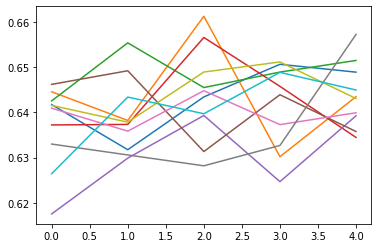

In [26]:
N_perm = 10
chance_cvl = []
for i in range(N_perm):
    print()
    cvl = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        Y = np.random.permutation(Y)
        Y_train, Y_test = Y[train_index,:], Y[test_index,:]
    #     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
    #     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
        cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    plt.plot(cvl)
    print(f"Training {i}, loss: {cvl[-1]}")
    chance_cvl.append(cvl)

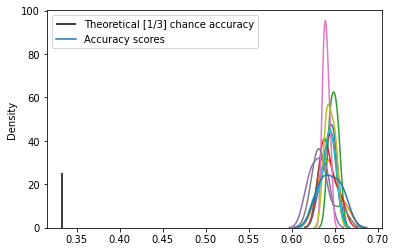

In [27]:
plt.vlines([1/3], 0, 25, colors='k', linestyles='solid', label='Theoretical [1/3] chance accuracy')
for i in chance_cvl:
    sns.kdeplot(i)
sns.kdeplot(cross_validation_scores, label="Accuracy scores")
plt.legend()

In [28]:
chance_scores = np.array(chance_cvl).mean(axis=0)
chance_scores

array([0.63717252, 0.63894372, 0.64390286, 0.64141005, 0.64385323])

In [29]:
cross_validation_scores = np.array(cross_validation_scores)
cross_validation_scores

array([0.65982181, 0.62950242, 0.64329708, 0.63664788, 0.65441006])

In [30]:
from scipy.stats import mannwhitneyu, ttest_ind
U, p = mannwhitneyu(chance_scores, cross_validation_scores)
print(U, p)

12.0 1.0


In [31]:
t, p = ttest_ind(chance_scores, cross_validation_scores)
print(t, p)

-0.6422912772723238 0.5386502736221305
